In [444]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse import linalg

In [445]:
def get_neighbor_pixels(image, coord, T):
    x, y = coord
    s_coord, s_value = [], []
    
    for i in range(-T, T+1):
        for j in range(-T, T+1):
            if i == j == 0: continue
            try: 
                if x + i < 0 or y + j < 0: continue
                s = image[x+i][y+j] 
                s_coord.append((x+i, y+j))
                s_value.append(s)
            except IndexError: continue     
    return s_coord, s_value


def weight_f(mean, var, r, s): # option 2
    eps = 1e-6
    return 1 + ((r-mean)*(s-mean))/(var+eps)


def get_weight(r, values):
    n_mean, n_var = np.mean(values), np.var(values)
    weight_neighbor = [weight_f(n_mean, n_var, r, i) for i in values]
    normalized_neighbor = weight_neighbor / np.sum(weight_neighbor)
    return normalized_neighbor


def get_neighbor_matrix(image, T):
    height, width = image.shape
    neighborhood = sparse.lil_matrix((height * width, height * width)) # 337,500 * 337,500
    numbering = 0

    for i in range(height):
        for j in range(width):
            r = img[i][j]
            coords, values = get_neighbor_pixels(img, (i, j), T)
            normalized_neighbor = get_weight(r, values)
            for (x, y), weight in zip(coords, normalized_neighbor):
                neighborhood[numbering, x * width + y] = weight
            numbering += 1
    return neighborhood


def get_scribbles(scribbles_img):
    scribbles = cv2.imread(scribbles_img)
    h, w, c = scribbles.shape
    scribbles_back, scribbles_fore = np.zeros((h * w,)), np.zeros((h * w,))
    numbering = 0

    for i in range(height):
        for j in range(width):
            if scribbles[i][j][2] == 1: scribbles_back[numbering] = 1
            elif scribbles[i][j][2] == 2: scribbles_fore[numbering] = 1
            numbering += 1
    return scribbles_back, scribbles_fore

# I - w
def get_identity_weights(neighbor, scribbles_back, scribbles_fore, height, width):
    identity_matrix = sparse.identity(height * width)
    for i in range(neighbor.shape[0]):
        if scribbles_back[i] == 1 or scribbles_fore[i] == 1:
            neighbor[i, :] = 0
    return identity_matrix - neighbor


def least_sq(i_minus_weight, scribbles_back, scribbles_fore, h, w):
    x_back = linalg.lsqr(i_minus_weight, scribbles_back)
    x_fore = linalg.lsqr(i_minus_weight, scribbles_fore)
    
    n = np.stack([x_back[0], x_fore[0]], axis=0)
    c = n.argmax(axis=0)
    return np.reshape(c, (h, w))


def get_ground_truth(gt_img):
    gt = cv2.imread(gt_img, cv2.COLOR_BGR2RGB)
    return np.sum(gt, axis=2)


def get_iou_score(gt, spm):
    intersection, union = np.logical_and(gt, sp_m), np.logical_or(gt, sp_m)
    score = np.sum(intersection) * 100 / np.sum(union)
    print('Intersection =', np.sum(intersection))
    print('Union =', np.sum(union))
    print('IoU score =', score)
    return intersection, union, score


def make_plot(T, gt, spm, intersection, union):
    plt.title(f'T={T} Ground Truth')
    plt.imshow(gt)
    plt.savefig(f't{T}-gt.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')
    
    plt.title(f'T={T} Output')
    plt.imshow(sp_m)
    plt.savefig(f't{T}-output.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')
    
    plt.title(f'T={T} Intersection')
    plt.imshow(intersection)
    plt.savefig(f't{T}-intersection.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')
    
    plt.title(f'T={T} Union')
    plt.imshow(union)
    plt.savefig(f't{T}-union.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')
    print('Done')
    

def all_in_one(original_img, scribble_img, gt_img, T):
    img = cv2.imread(original_img, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape
    
    neighbor = get_neighbor_matrix(img, T)
    scribbles_back, scribbles_fore = get_scribbles(scribble_img)
    i_minus_weight = get_identity_weights(neighbor, scribbles_back, scribbles_fore, height, width)
    spm = least_sq(i_minus_weight, scribbles_back, scribbles_fore, height, width)
    gt = get_ground_truth(gt_img)
    intersection, union, score = get_iou_score(gt, spm)
    make_plot(T, gt, spm, intersection, union)

In [446]:
original = 'Emily-In-Paris-gray.png'
scribble = 'Emily-In-Paris-scribbles.png'
gt_img = 'Emily-In-Paris-gt.png'

all_in_one(original, scribble, gt_img, 1)
all_in_one(original, scribble, gt_img, 2)
all_in_one(original, scribble, gt_img, 3)
all_in_one(original, scribble, gt_img, 4)
all_in_one(original, scribble, gt_img, 5)

KeyboardInterrupt: 

In [154]:
naver = get_neighbor_matrix(img, 2)

In [155]:
scribbles_back, scribbles_fore = get_scribbles('Emily-In-Paris-scribbles.png')

In [189]:
identity_matrix = sparse.identity(height * width)

In [190]:
for i in range(naver.shape[0]):
    if scribbles_back[i] == 1 or scribbles_fore[i] == 1:
        naver[i, :] = 0
        
i_minus_weight = identity_matrix - naver

In [232]:
x_back = linalg.lsqr(i_minus_weight, scribbles_back)
x_fore = linalg.lsqr(i_minus_weight, scribbles_fore)


34.46601995229721


In [259]:
n = np.stack([x_back[0], x_fore[0]], axis=0)
c = n.argmax(axis=0)
# v = np.reshape(c, (h, w))
n.shape
c

array([0, 0, 0, ..., 1, 1, 1])

In [260]:
sp_m = np.reshape(c, (h, w))

In [261]:
sp_m.shape

(450, 750)

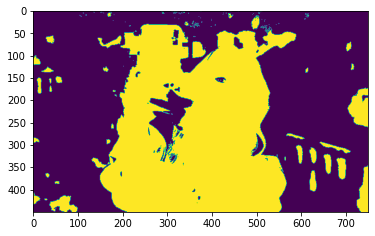

In [262]:
plt.imshow(sp_m)

In [306]:
sp_m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [427]:
gt = cv2.imread('Emily-In-Paris-gt.png', cv2.COLOR_BGR2RGB)
gt = np.sum(gt, axis=2)

(450, 750, 3)

In [432]:
intersection = np.logical_and(gt, sp_m)
union = np.logical_or(gt, sp_m)
print(np.sum(intersection))
print(np.sum(union))
print(np.sum(intersection) * 100 / np.sum(union))

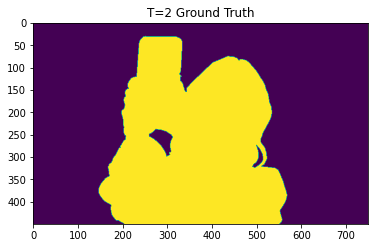

In [429]:
plt.title('T=2 Ground Truth')
plt.imshow(gt)
plt.savefig('t2-gt.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')

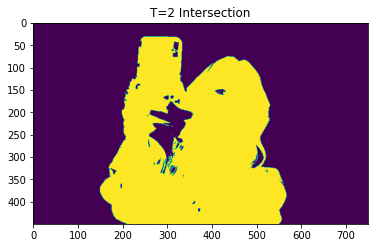

In [438]:
plt.title('T=2 Output')
plt.imshow(sp_m)
plt.savefig('t2-output.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')

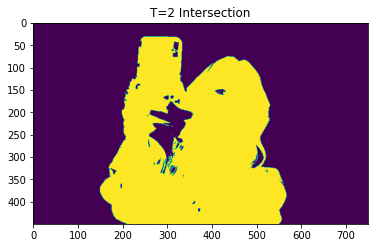

In [435]:
plt.title('T=2 Intersection')
plt.imshow(intersection)
plt.savefig('t2-intersection.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')

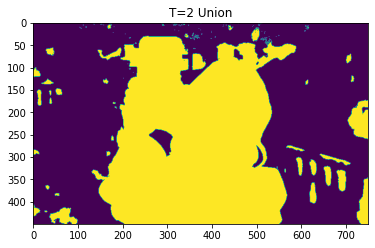

In [436]:
plt.title('T=2 Union')
plt.imshow(union)
plt.savefig('t2-union.png', facecolor='#eeeeee', edgecolor='blue', bbox_inches='tight')